<a href="https://colab.research.google.com/github/tth-97/AI-practice/blob/main/base_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from PIL import Image

In [3]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cuda


In [5]:
##### AutoEncoder 모델 코드 #####

class Encoder(nn.Module):
    def __init__(self,):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(nn.Conv2d(3, 6, 5, 1, 0),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2, 2),
                                    nn.Conv2d(6, 16, 5, 1, 0),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2, 2),
        )
    def forward(self, input):
        return self.encode(input)


class Decoder(nn.Module):
    def __init__(self, ):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(nn.Conv2d(16, 16, 13, 1, 12),
                                    nn.ReLU(),
                                    nn.Conv2d(16, 16, 13, 1, 12),
                                    nn.ReLU(),
                                    nn.Conv2d(16, 6, 13, 1, 12),
                                    nn.ReLU(),
                                    nn.Conv2d(6, 6, 13, 1, 12),
                                    nn.ReLU(),
                                    nn.Conv2d(6, 6, 13, 1, 12),
                                    nn.ReLU(),
                                    nn.Conv2d(6, 3, 19, 1, 18),
                                    nn.Tanh(),
        )
    def forward(self, input):
        return self.decode(input)
        
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, input):
        z = self.encoder(input)
        x_hat = self.decoder(z)
        return z, x_hat

In [6]:
transform = transforms.Compose([transforms.Resize((100, 100)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.Flowers102(root="StanfordCars/", 
                    split='train', 
                    transform=transform,
                    download=True)
test_dataset = torchvision.datasets.Flowers102(root="StanfordCars/", 
                    split='test',
                    transform=transform,
                    download=True)

100%|██████████| 344862509/344862509 [00:15<00:00, 21815004.43it/s]


Extracting StanfordCars/flowers-102/102flowers.tgz to StanfordCars/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1441164.00it/s]


100%|██████████| 14989/14989 [00:00<00:00, 27251158.50it/s]


In [11]:
##### AutoEncoder 학습 코드 #####

batch_size = 255

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

autoencoder = AutoEncoder().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

epochs = 100
train_avg_costs = []

autoencoder.train()
for epoch in range(epochs):
    autoencoder.train()
    avg_cost = 0
    total_batch_num = len(train_dataloader)
    
    for b_x, b_y in train_dataloader:
        b_x = b_x.to(device)
        z, b_x_hat = autoencoder(b_x) # forward propagation
        loss = criterion(b_x_hat, b_x) # get cost
        
        avg_cost += loss / total_batch_num
        optimizer.zero_grad()
        loss.backward() # backward propagation
        optimizer.step() # update parameters
    train_avg_costs.append(avg_cost.detach())
    print('Epoch : {} / {}, cost : {}'.format(epoch+1, epochs, avg_cost))


Epoch : 1 / 100, cost : 0.3591901659965515
Epoch : 2 / 100, cost : 0.3416145145893097
Epoch : 3 / 100, cost : 0.32485705614089966
Epoch : 4 / 100, cost : 0.3096267580986023
Epoch : 5 / 100, cost : 0.2940369248390198
Epoch : 6 / 100, cost : 0.27431225776672363
Epoch : 7 / 100, cost : 0.25843337178230286
Epoch : 8 / 100, cost : 0.24487638473510742
Epoch : 9 / 100, cost : 0.2342151552438736
Epoch : 10 / 100, cost : 0.2254345715045929
Epoch : 11 / 100, cost : 0.21842142939567566
Epoch : 12 / 100, cost : 0.21211373805999756
Epoch : 13 / 100, cost : 0.20673272013664246
Epoch : 14 / 100, cost : 0.2023196816444397
Epoch : 15 / 100, cost : 0.1982765793800354
Epoch : 16 / 100, cost : 0.1949479877948761
Epoch : 17 / 100, cost : 0.1927739977836609
Epoch : 18 / 100, cost : 0.19010630249977112
Epoch : 19 / 100, cost : 0.18709561228752136
Epoch : 20 / 100, cost : 0.18500706553459167
Epoch : 21 / 100, cost : 0.18339593708515167
Epoch : 22 / 100, cost : 0.18183304369449615
Epoch : 23 / 100, cost : 0.18

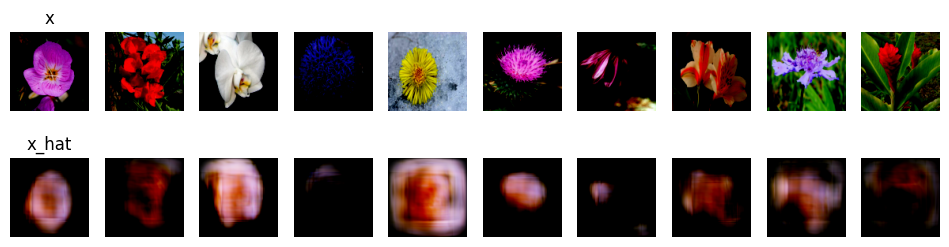

In [23]:
# autoencoder 학습 결과 확인 #

import matplotlib.pyplot as plt
import numpy as np

autoencoder.eval()
test_samples = torch.zeros((10, 3, 100, 100))
for i in range(10):
  test_samples[i] = test_dataset[100*i][0]
test_samples = test_samples.to(device)
z, test_output = autoencoder(test_samples)

fig, ax = plt.subplots(2, 10, figsize=(12,3))
ax[0][0].set_title('x')
ax[1][0].set_title('x_hat')
for i in range(10):
  ax[0][i].set_axis_off()
  ax[1][i].set_axis_off()
  #ax[0][i].imshow((np.transpose(test_samples[i].detach().cpu().numpy(), (1,2,0))*255).astype(np.uint8))
  #ax[1][i].imshow((np.transpose(test_output[i].detach().cpu().numpy(), (1,2,0))*255).astype(np.uint8))
  ax[0][i].imshow(np.transpose(test_samples[i].detach().cpu().numpy(), (1,2,0)))
  ax[1][i].imshow(np.transpose(test_output[i].detach().cpu().numpy(), (1,2,0)))
plt.show()

In [29]:
print(train_avg_costs)

[tensor(0.3592, device='cuda:0'), tensor(0.3416, device='cuda:0'), tensor(0.3249, device='cuda:0'), tensor(0.3096, device='cuda:0'), tensor(0.2940, device='cuda:0'), tensor(0.2743, device='cuda:0'), tensor(0.2584, device='cuda:0'), tensor(0.2449, device='cuda:0'), tensor(0.2342, device='cuda:0'), tensor(0.2254, device='cuda:0'), tensor(0.2184, device='cuda:0'), tensor(0.2121, device='cuda:0'), tensor(0.2067, device='cuda:0'), tensor(0.2023, device='cuda:0'), tensor(0.1983, device='cuda:0'), tensor(0.1949, device='cuda:0'), tensor(0.1928, device='cuda:0'), tensor(0.1901, device='cuda:0'), tensor(0.1871, device='cuda:0'), tensor(0.1850, device='cuda:0'), tensor(0.1834, device='cuda:0'), tensor(0.1818, device='cuda:0'), tensor(0.1808, device='cuda:0'), tensor(0.1785, device='cuda:0'), tensor(0.1764, device='cuda:0'), tensor(0.1743, device='cuda:0'), tensor(0.1721, device='cuda:0'), tensor(0.1703, device='cuda:0'), tensor(0.1673, device='cuda:0'), tensor(0.1645, device='cuda:0'), tensor(0.

In [24]:
##### Classifier 모델 코드 #####

class Classifier(nn.Module):
    def __init__(self, ):
        super(Classifier, self).__init__()
        self.classify = nn.Sequential(nn.Conv2d(16, 32, 3, 1, 0),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2, 2),
                                      nn.Conv2d(32, 64, 3, 1, 0),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2, 2),
                                      nn.Flatten(),
                                      nn.Linear(64*4*4, 512),
                                      nn.ReLU(),
                                      nn.Linear(512, 102)
        )
    def forward(self, input):
        return self.classify(input)

In [25]:
##### Classifier 학습 코드 #####

classifier = Classifier().to(device)
cls_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    [
        {"params": autoencoder.parameters(), "lr": 0.001},
        {"params": classifier.parameters(), "lr": 0.001},
    ]
)

autoencoder.train()
classifier.train()
total_batch_num = len(train_dataloader)

epochs = 60
classifier_avg_costs = []

for epoch in range(epochs):
  avg_cost = 0

  for b_x, b_y in train_dataloader:
    b_x = b_x.to(device)
    b_y = b_y.to(device)
    z, b_x_hat = autoencoder(b_x)
    logits = classifier(z) # classification
    loss = cls_criterion(logits, b_y) # get cost

    avg_cost += loss / total_batch_num

    optimizer.zero_grad()
    loss.backward() # backward propagation
    optimizer.step() # update param

  classifier_avg_costs.append(avg_cost.detach())
  print('Epoch : {} / {}, cost : {}'.format(epoch+1, epochs, avg_cost))

Epoch : 1 / 60, cost : 4.631750106811523
Epoch : 2 / 60, cost : 4.58737325668335
Epoch : 3 / 60, cost : 4.421422958374023
Epoch : 4 / 60, cost : 4.160083293914795
Epoch : 5 / 60, cost : 3.9269657135009766
Epoch : 6 / 60, cost : 3.7078518867492676
Epoch : 7 / 60, cost : 3.5131521224975586
Epoch : 8 / 60, cost : 3.3277056217193604
Epoch : 9 / 60, cost : 3.1386208534240723
Epoch : 10 / 60, cost : 2.9577856063842773
Epoch : 11 / 60, cost : 2.8104329109191895
Epoch : 12 / 60, cost : 2.615046501159668
Epoch : 13 / 60, cost : 2.4461722373962402
Epoch : 14 / 60, cost : 2.2446470260620117
Epoch : 15 / 60, cost : 2.074981689453125
Epoch : 16 / 60, cost : 1.8791509866714478
Epoch : 17 / 60, cost : 1.6696159839630127
Epoch : 18 / 60, cost : 1.5423964262008667
Epoch : 19 / 60, cost : 1.368419885635376
Epoch : 20 / 60, cost : 1.1711409091949463
Epoch : 21 / 60, cost : 0.9969943165779114
Epoch : 22 / 60, cost : 0.7676456570625305
Epoch : 23 / 60, cost : 0.6478798389434814
Epoch : 24 / 60, cost : 0.47

In [30]:
print(classifier_avg_costs)

[tensor(4.6318, device='cuda:0'), tensor(4.5874, device='cuda:0'), tensor(4.4214, device='cuda:0'), tensor(4.1601, device='cuda:0'), tensor(3.9270, device='cuda:0'), tensor(3.7079, device='cuda:0'), tensor(3.5132, device='cuda:0'), tensor(3.3277, device='cuda:0'), tensor(3.1386, device='cuda:0'), tensor(2.9578, device='cuda:0'), tensor(2.8104, device='cuda:0'), tensor(2.6150, device='cuda:0'), tensor(2.4462, device='cuda:0'), tensor(2.2446, device='cuda:0'), tensor(2.0750, device='cuda:0'), tensor(1.8792, device='cuda:0'), tensor(1.6696, device='cuda:0'), tensor(1.5424, device='cuda:0'), tensor(1.3684, device='cuda:0'), tensor(1.1711, device='cuda:0'), tensor(0.9970, device='cuda:0'), tensor(0.7676, device='cuda:0'), tensor(0.6479, device='cuda:0'), tensor(0.4753, device='cuda:0'), tensor(0.3575, device='cuda:0'), tensor(0.2635, device='cuda:0'), tensor(0.1906, device='cuda:0'), tensor(0.1525, device='cuda:0'), tensor(0.1081, device='cuda:0'), tensor(0.0820, device='cuda:0'), tensor(0.

In [26]:
##### Classifier 정확도 측정 코드 #####

correct = 0
total = 0

classifier.eval()
autoencoder.eval()

for b_x, b_y in test_dataloader:
  b_x = b_x.to(device)
  b_y = b_y.to(device)
  with torch.no_grad():
    z, b_x_hat = autoencoder(b_x)
    logits = classifier(z)
  
  predicts = torch.argmax(logits, dim=1)

  total += len(b_y)
  correct += (predicts == b_y).sum().item()

print(f'Accuracy of the netwark on test images: {100 * correct / total} %')


Accuracy of the netwark on test images: 15.20572450805009 %
